# Modelling
<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* Ridge and Lasso Regularization (add on to linear modelling?)

<u> Tests using the following variables:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables:
    * Sensor_id
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   


Normalise variables: should this be with MinMax or StandardScaler??


Process:
* Keep only data from sensor's with relatively complete data
* Split data into training ( 75%) and test (25%)
* Define the models to use in testing (linear regression, random forest, xgboost)
* Define the error metrics to use in evaluating the model performance

In [283]:
import copy
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, mean_squared_error,r2_score, accuracy_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import MinMaxScaler
import time as thetime
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
from time import time
from sklearn.inspection import permutation_importance
from scipy import stats
import math
import datashader as ds
from datashader.mpl_ext import dsshow

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import multiprocessing

# To display tables in HTML output
from IPython.display import HTML, display

from Functions import *

# Code from: https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
def using_datashader(ax, x, y, normalisation):
    df = pd.DataFrame(dict(x=x, y=y))
    dsartist = dsshow(df,ds.Point("x", "y"),ds.count(), vmin=0.1, vmax=100,norm=normalisation,aspect="auto",ax=ax)
    plt.colorbar(dsartist, ax=ax)
    
def run_model_with_cv(model,model_name, metrics, cv, X_train, Y_train, regex_name, regex_pattern):
    print("Running {} model, variables include {}".format(model_name,  regex_name))

    # Filter columns using the regex pattern in function input
    X_train = X_train[X_train.columns.drop(list(X_train.filter(regex=regex_pattern)))].copy()
    
    # Get list of all features
    feature_list = list(X_train.columns)
        
    # Perform cross validation, time how long it takes
    start = time()
    model_output = cross_validate(model, X_train, Y_train, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
    end = time()
    
    #  Create a dataframe containng scores for each performance metric
    df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
         'r2': round(abs(model_output['test_r2'].mean()),2), 'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                     index =["{}_{}".format(model_name, regex_name)])
    
    # Get the estimators 
    estimators = model_output['estimator']
    
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    return [estimators, df, feature_list]    


def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)
    permuted_score = mean_absolute_error(X_permuted, y)
#     permuted_score = model.score(X_permuted, y, scoring= "neg_mean_absolute_error")
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance


def perform_permutation_importance_manually(model, X, y, n_repeats=10):
    """Manual implementation of permutation importance.
    From: https://inria.github.io/scikit-learn-mooc/python_scripts/dev_features_importance.html
    Calculate importance score for each feature."""

    importances = []
    for curr_feat in X.columns:
        list_feature_importance = []
        for n_round in range(n_repeats):
            list_feature_importance.append(
                get_feature_importance(model, X, y, curr_feat))

        importances.append(list_feature_importance)

    return {'importances_mean': np.mean(importances, axis=1),
            'importances_std': np.std(importances, axis=1),
            'importances': importances}

### Read in formatted data

In [97]:
data = pd.read_csv("formatted_data_for_modelling.csv", index_col = False)

### Keep only sensors with relatively complete data

In [3]:
# ### Filter to include just sensors which we know have quite complete data 
# data = data[data['sensor_id'].isin([2,6,9,10,14,18])]
# data.reset_index(inplace=True, drop = True)

In [98]:
# data = data.drop(['Pressure', 'Humidity'],axis=1) # seem obviously irrelevant
data = data.drop(['sensor_id'],axis=1) # don't want this included
# Get rid of columns in which none of the sensors have a value
for column in data.columns:
    if np.nanmax(data[column]) ==0:
        del data[column]

### Add a random variable (to compare performance of other variables against)

In [99]:
data['random'] = np.random.random(size=len(data))

## Prepare data for modelling 
### Split into predictor/predictand variables

In [100]:
# The predictor variables
Xfull = data.drop(['hourly_counts'], axis =1)
# The variable to be predicted
Yfull = data['hourly_counts'].values

### Split into training and test data

In [101]:
# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(Xfull, Yfull, test_size=0.75, random_state=123)

### Standardize both training and testing data

In [102]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## Define models (linear regression, random forest and XGBoost)

In [103]:
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 64)
xgb_model = XGBRegressor(random_state=1, n_jobs = 200)
et_model =ExtraTreesRegressor (n_estimators = 500, random_state = 1, n_jobs = 64)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validatio

In [104]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
cv_parameters = KFold(n_splits=10, random_state=1, shuffle=True)

### Define regex's to remove columns not needed in various splits of removing column

In [31]:
column_regex_dict = {'withsubtypes':'buildings$|furniture$|landmarks$'}
#                      'nosubtyes':'buildings_|furniture_|landmarks_|sensor_id',
#                      'time_and_weather':'buildings|furniture|landmarks|h_|lights|avg_n_floors|betweenness',
#                       'just_location_features':'buildings$|furniture$|landmarks$|school_holiday|public_holiday|Temp|Humidity|Pressure|Rain|WindSpeed|Sin|Cos'}

### Loop through each combination of the models, and the variables to include in the modelling

In [32]:
# Dataframe to store the scores for each model
error_metric_scores = pd.DataFrame()

# Dictionary to store dataframes of feature importance scores
feature_importance_scores ={}

models_dict = {"linear_regression": lr_model, "xgboost":xgb_model, "random_forest":rf_model, "extra_trees":et_model}
for model_name,model in models_dict.items():
    for regex_name, regex in column_regex_dict.items():
        # Run the model: return the estimators and a dataframe containing evaluation metrics
        estimators, error_metrics_df, feature_list = run_model_with_cv(
            model, model_name, error_metrics, cv_parameters, X_train, Y_train, regex_name, regex) 
        # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
        error_metric_scores = error_metric_scores.append(error_metrics_df)
        
        # Create dataframe of feature importances (no feature importances for linear regression)
        if model_name != 'linear_regression':
            feature_importances = pd.DataFrame(index =[feature_list])
            for idx,estimator in enumerate(estimators):
                    feature_importances['Estimator{}'.format(idx)] = estimators[idx].feature_importances_
            feature_importance_scores["{}_{}".format(model_name, regex_name)] = feature_importances

Running linear_regression model, variables include withsubtypes
Ran in 0 minutes
Running xgboost model, variables include withsubtypes
Ran in 1 minutes
Running random_forest model, variables include withsubtypes
Ran in 6 minutes
Running extra_trees model, variables include withsubtypes
Ran in 4 minutes


In [33]:
error_metric_scores

,mae,r2,rmse
linear_regression_withsubtypes,224.21,0.47,316.94
xgboost_withsubtypes,87.92,0.86,162.49
random_forest_withsubtypes,79.60,0.86,160.19
extra_trees_withsubtypes,80.66,0.86,163.59


### Feature importances?

In [17]:
# feature_importance_scores["xgboost_withsubtypes"].sort_values('Estimator0', ascending = False)[0:10]

## Choose the best model 

Random Forest was the best performing model

## Fit the final model
For this, we use all of the training data

In [105]:
rf_final_model = RandomForestRegressor(n_estimators = 500, random_state = 1, n_jobs = 64)
rf_final_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=500, n_jobs=64, random_state=1)

### Use this model to make predictions

In [35]:
rf_predictions = rf_final_model.predict(X_test)

In [36]:
# Calculate the absolute errors
abs_errors = abs(rf_predictions - Y_test)
# Mean absolute percentage errors
mape = mean_absolute_percentage_error(Y_test, rf_predictions)
# Mean absolute error
mae = round(np.mean(abs_errors), 2)
# Calculate r2 value (well, just_rvalue, its squared in the print statement)
m, b, r_value, p_value, std_err = stats.linregress(rf_predictions, Y_test)
# RMSE
MSE = np.square(np.subtract(rf_predictions,Y_test)).mean() 
RMSE = math.sqrt(MSE)

# Add to Dataframe
accuracy_results_rf = pd.DataFrame({'MAPE': mape, 'MAE':mae, 'RMSE':RMSE, 'R2':(r_value**2) }, index =['RandomForest'])

### Find feature importances

In [263]:
# Get numerical feature importances
rf_importances = list(rf_final_model.feature_importances_)
rf_feature_importances = pd.DataFrame({'feature': X_test.columns,'importance':rf_importances})      
rf_feature_importances= rf_feature_importances.sort_values(by = 'importance', ascending = True)
# rf_feature_importances = rf_feature_importances[0:10]

rf_feature_importances_overrandom = rf_feature_importances[rf_feature_importances['importance']>rf_feature_importances.query("feature=='random'")["importance"].values[0]]

### Find the permutation importance

In [284]:
perm_importance_result_train = perform_permutation_importance_manually(rf_final_model, X_train, Y_train, n_repeats=10)

ValueError: y_true and y_pred have different number of output (46!=1)

In [258]:
permutation_feature_importances = pd.DataFrame({'feature_name':X_train.columns.tolist(),
               'importances_mean':perm_importance_result_train['importances_mean'],
              'importances_std': perm_importance_result_train['importances_std'][indices]}).sort_values(by='importances_mean',ascending=True)
permutation_feature_importances.reset_index(inplace=True, drop=True)
permutation_feature_importances_overrandom = permutation_feature_importances[permutation_feature_importances['importances_mean']>permutation_feature_importances.query("feature_name=='random'")["importances_mean"].values[0]]

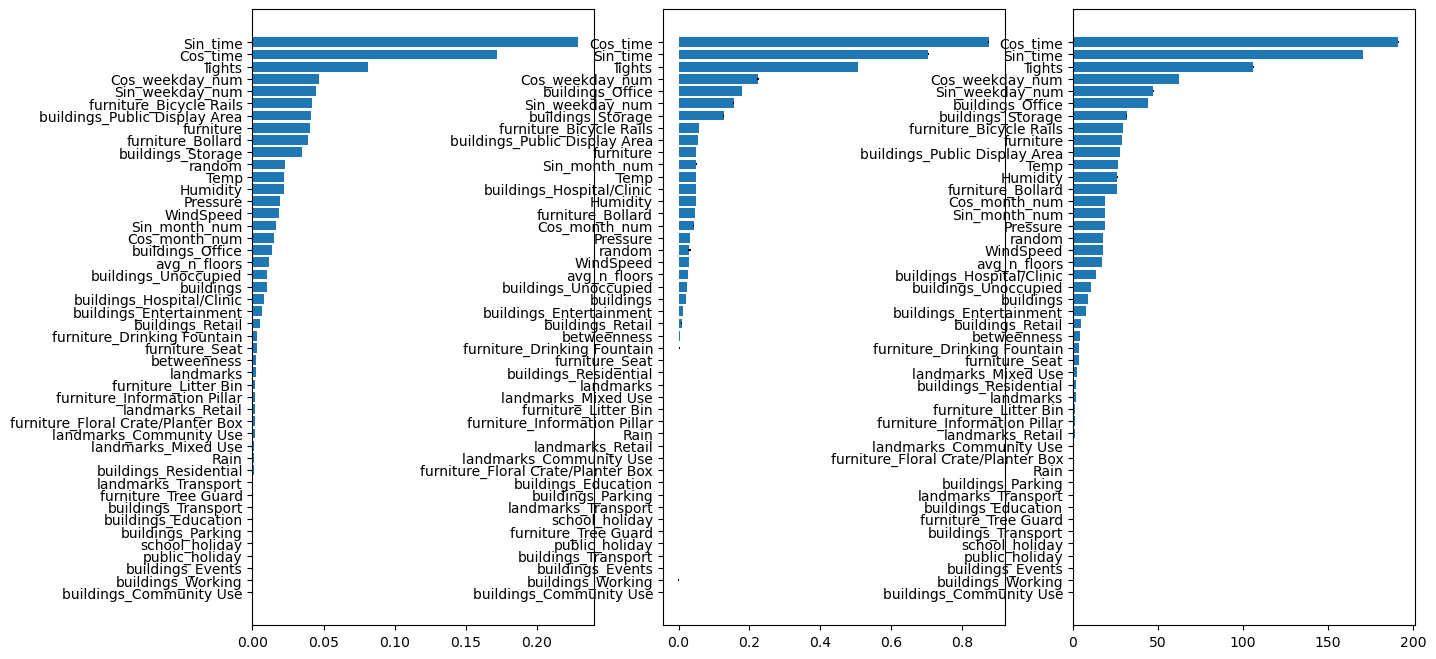

In [273]:
fig, axs = plt.subplots(ncols = 3, figsize=(15,8))
axs[0].barh(range(len(rf_feature_importances['importance'])), rf_feature_importances["importance"])
axs[0].set_yticks(range(len(rf_feature_importances["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances["feature"]))

axs[1].barh(range(len(permutation_feature_importances['importances_mean'])),
         permutation_feature_importances['importances_mean'],
         xerr=permutation_feature_importances['importances_std'])
axs[1].set_yticks(range(len(permutation_feature_importances['importances_mean'])))
_ = axs[1].set_yticklabels(permutation_feature_importances['feature_name'])    

axs[2].barh(range(len(eli5_permutation_fi['Feature_importance'])),
         eli5_permutation_fi['Feature_importance'],
         xerr=eli5_permutation_fi['Feature_importance_std'])
axs[2].set_yticks(range(len(eli5_permutation_fi['Feature_importance'])))
_ = axs[2].set_yticklabels(eli5_permutation_fi['Feature_name'])   

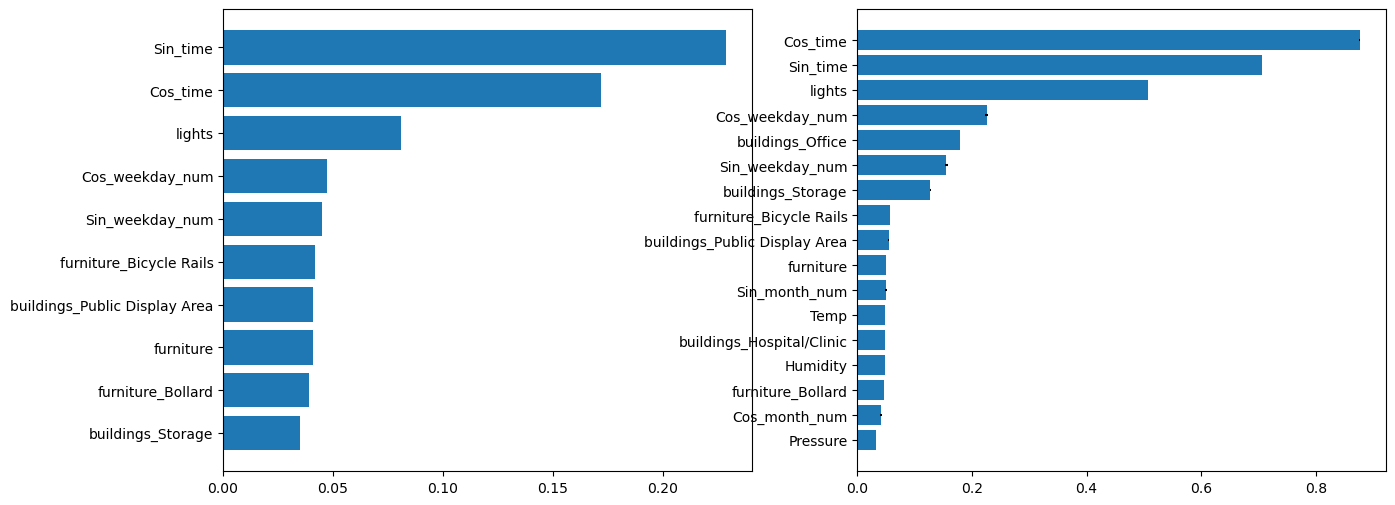

In [265]:
fig, axs = plt.subplots(ncols = 3, figsize=(15,6))
axs[0].barh(range(len(rf_feature_importances_overrandom['importance'])), rf_feature_importances_overrandom["importance"])
axs[0].set_yticks(range(len(rf_feature_importances_overrandom["feature"])))
_ = axs[0].set_yticklabels(np.array(rf_feature_importances_overrandom["feature"]))

axs[1].barh(range(len(permutation_feature_importances_overrandom['importances_mean'])),
         permutation_feature_importances_overrandom['importances_mean'],
         xerr=permutation_feature_importances_overrandom['importances_std'])
axs[1].set_yticks(range(len(permutation_feature_importances_overrandom['importances_mean'])))
_ = axs[1].set_yticklabels(permutation_feature_importances_overrandom['feature_name'])   

axs[2].barh(range(len(eli5_permutation_fi['Feature_importance'])),
         eli5_permutation_fi['Feature_importance'],
         xerr=eli5_permutation_fi['Feature_importance_std'])
axs[2].set_yticks(range(len(eli5_permutation_fi['Feature_importance'])))
_ = axs[2].set_yticklabels(eli5_permutation_fi['Feature_name'])   

In [267]:
# Using form eli5.sklearn import PermutationImportance
#instantiate permuter object
permuter = PermutationImportance(rf_final_model, scoring='neg_mean_absolute_error', cv='prefit', n_iter=2, random_state=42)
permuter.fit(X_train, Y_train)
eli5_permutation_fi = pd.DataFrame({'Feature_name':X_train.columns,
              'Feature_importance':permuter.feature_importances_,
              'Feature_importance_std': permuter.feature_importances_std_}).sort_values('Feature_importance', ascending = False)

PermutationImportance(estimator=RandomForestRegressor(n_estimators=500,
                                                      n_jobs=64,
                                                      random_state=1),
                      n_iter=2, random_state=42,
                      scoring='neg_mean_absolute_error')

In [272]:
eli5_permutation_fi = pd.DataFrame({'Feature_name':X_train.columns,
              'Feature_importance':permuter.feature_importances_,
              'Feature_importance_std': permuter.feature_importances_std_}).sort_values('Feature_importance', ascending = True)
eli5_permutation_fi

,Feature_name,Feature_importance,Feature_importance_std
25,buildings_Community Use,0.032984,0.000443
32,buildings_Working,0.037681,0.000091
33,buildings_Events,0.052362,0.001028
5,public_holiday,0.057369,0.001442
6,school_holiday,0.265239,0.000800
38,buildings_Transport,0.281721,0.000593
20,furniture_Tree Guard,0.325281,0.005863
37,buildings_Education,0.399858,0.007686
22,landmarks_Transport,0.460052,0.001139
36,buildings_Parking,0.468201,0.002056


### Plots!?

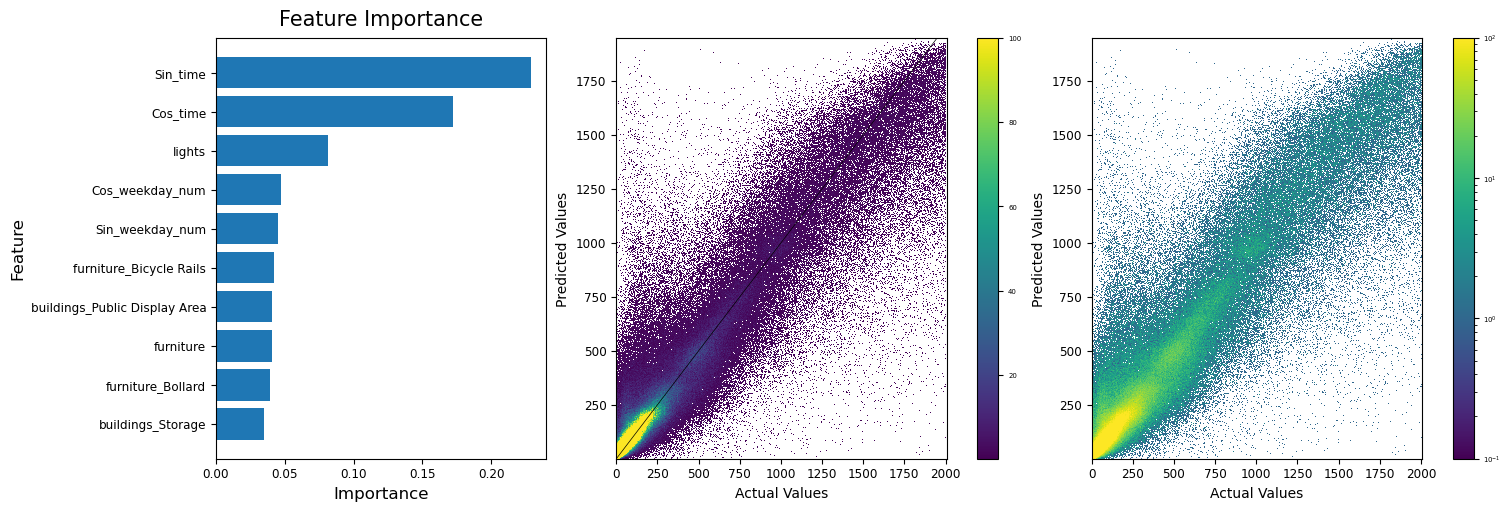

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=3, constrained_layout=True, figsize = (15,5))

axs[0].barh(rf_feature_importances['feature'][:10], rf_feature_importances['importance'][:10])
axs[0].invert_yaxis()
plt.rcParams.update({'font.size': 5})
axs[0].set_title("Feature Importance", fontsize=15, y=1.01)
axs[0].set_xlabel('Importance', fontsize = 12)
axs[0].set_ylabel('Feature', fontsize = 12)
axs[0].xaxis.set_tick_params(labelsize='xx-large')
axs[0].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[1],Y_test, rf_predictions, 'linear')
axs[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
axs[1].xaxis.set_tick_params(labelsize='xx-large')
axs[1].yaxis.set_tick_params(labelsize='xx-large')

using_datashader(axs[2], Y_test, rf_predictions, 'log')
# axs[2].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], c='k', lw=0.5)
axs[2].set_ylabel("Predicted Values", size=10)
axs[2].set_xlabel("Actual Values", size=10)
axs[2].xaxis.set_tick_params(labelsize='xx-large')
axs[2].yaxis.set_tick_params(labelsize='xx-large')

plt.show()